In [1]:
import numpy as np
import pandas as pd
from pycaret.regression import *
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
def Haversine(lat1: float, lon1: float, lat2: float, lon2: float)-> float:
    lon1, lon2, lat1, lat2 = map(np.radians, [lon1, lon2, lat1, lat2])
    diffLon = lon2 - lon1
    diffLat = lat2 - lat1
    Distance = 2 * 6371 * np.arcsin(
        np.sqrt(
            np.sin(diffLat/2)**2 +
            np.cos(lat1)*np.cos(lat2)*
            np.sin(diffLon/2)**2
        )
    )
    return Distance

In [3]:
dfUber = pd.read_csv('uber.csv')

In [4]:
dfUber['Distance'] = Haversine(
    dfUber['pickup_latitude'],
    dfUber['pickup_longitude'],
    dfUber['dropoff_latitude'],
    dfUber['dropoff_longitude']
    )

In [5]:
del dfUber['pickup_latitude']
del dfUber['pickup_longitude']
del dfUber['dropoff_latitude']
del dfUber['dropoff_longitude']

In [6]:
dfUber = dfUber[dfUber['fare_amount'] >= 1]
dfUber = dfUber[dfUber['fare_amount'] <=80]

In [7]:
dfUber = dfUber[dfUber['Distance'] <= 50]
dfUber = dfUber[dfUber['Distance'] >= 0.1]

In [8]:
dfUber = dfUber[dfUber['passenger_count'] >= 1]
dfUber = dfUber[dfUber['passenger_count'] <= 4]

In [9]:
dfUber['pickup_datetime'] = pd.to_datetime(dfUber['pickup_datetime'] )
dfUber['Hour'] = dfUber['pickup_datetime'].apply(lambda x: x.hour)
dfUber['Minute'] = dfUber['pickup_datetime'].apply(lambda x: x.minute)
dfUber['Day'] = dfUber['pickup_datetime'].apply(lambda x: x.dayofweek)
del dfUber['pickup_datetime']

In [10]:
fig = make_subplots(rows=3, cols=1)

In [11]:
fig.add_trace(
    go.Box(
        x=dfUber['Distance'],
        name='Distância'
    ),
    row=1,
    col=1
)

fig.add_trace(
    go.Box(
        x=dfUber['fare_amount'],
        name='Preço'
    ),
    row=2,
    col=1
)

fig.add_trace(
    go.Bar(
        y=dfUber['passenger_count'].value_counts(),
        name='Quantidade de Passageiros',
        x=[1,2,3,4]
    ),
    row=3,
    col=1
)

In [12]:
fig.show()

In [14]:
del dfUber['Unnamed: 0']
del dfUber['key']

In [15]:
EnvRegr = setup(dfUber, target='fare_amount', normalize=True)

In [16]:
best = create_model('lightgbm')

In [17]:
UberMLTunned = tune_model(best)

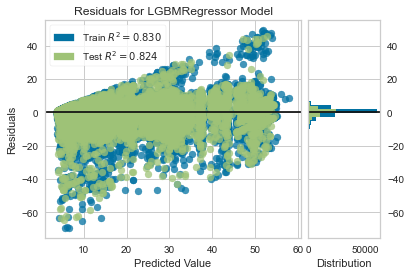

In [18]:
plot_model(UberMLTunned)

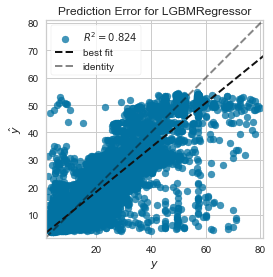

In [19]:
plot_model(UberMLTunned, plot ='error')

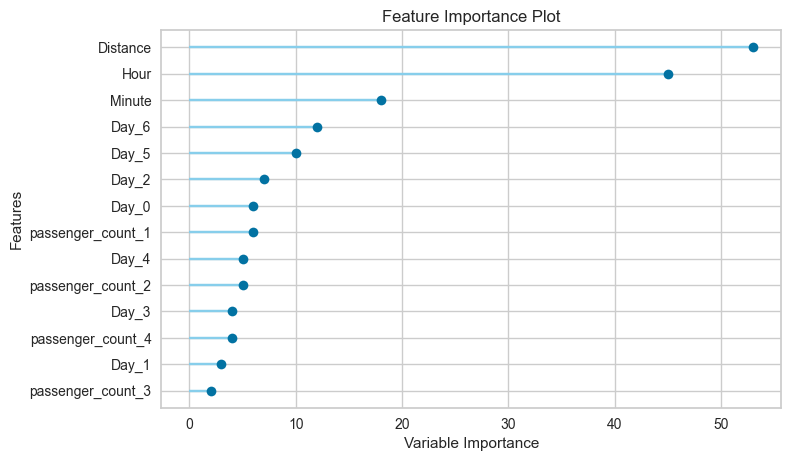

In [20]:
plot_model(UberMLTunned, plot ='feature_all')

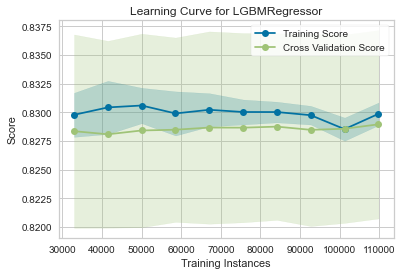

In [21]:
plot_model(UberMLTunned, plot ='learning')

In [22]:
UberMLFinal = finalize_model(UberMLTunned)

In [23]:
jsCode = convert_model(UberMLTunned, 'javascript')
arquivoJs = open('scoreModel.js', 'a+')
arquivoJs.write('export '+jsCode)
arquivoJs.close()

In [24]:
save_model(UberMLFinal, 'UberPrice')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='fare_amount', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.4,
                                importance_type='split', learning_rate=0.3,
                                max_depth=-1, min_child_samples=1,
                     

In [25]:
dfUberSam = dfUber.sample(frac=0.001)

In [26]:
dtLoad = load_model('UberPrice')
predict_model(dtLoad, data=dfUberSam)

Transformation Pipeline and Model Successfully Loaded


fare_amount  passenger_count  Distance  Hour  Minute  Day      Label
63189          12.9                1  2.577767    22      57    6   8.774656
134409          7.0                1  2.849883    13      44    1  10.236725
30130           5.5                1  0.715193    14      28    1   5.829010
45940           6.0                1  1.050148     1      44    5   4.903515
60229          11.4                1  4.947954     2      14    1  13.297933
...             ...              ...       ...   ...     ...  ...        ...
164383          6.9                1  1.406125    14      42    5   6.782369
168893          7.3                1  1.957648    14       6    6   8.758213
27652           4.5                1  0.935871    22      51    3   5.138636
100084          6.5                1  0.807171     9       4    1   5.540899
105139          9.0                2  1.214571    16      18    1   7.089686

[174 rows x 7 columns]